

**Функция:** $  f(x) = 418.9829n - \sum_{i=1}^{n} x_i \sin(\sqrt{|x_i|})  $ (функция Швефеля для 3 переменных).

**Оптимизация:** Метод имитации отжига с нелинейным охлаждением.

**Сравнение:**  с результатами, полученными методом генетических алгоритмов. Исследовать влияние различных стратегий охлаждения на результаты.


Построим 3х мерный график Функции Швефеля, для наглядности

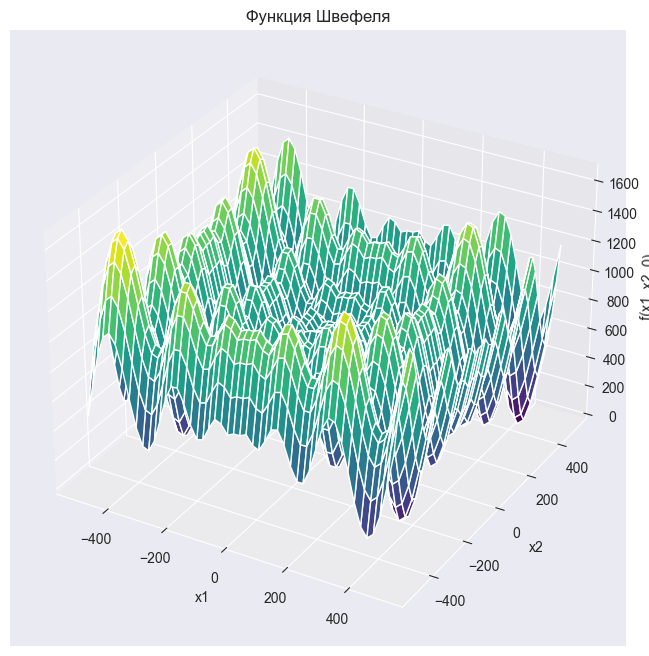

In [62]:
import numpy as np
import matplotlib.pyplot as plt

def schwefel_function(x):
    """
    Функция Швефеля
    """
    n = len(x)
    return 418.9829 * n - np.sum(x * np.sin(np.sqrt(np.abs(x))))

def plot_schwefel():
    """
    Построение графика функции Швефеля для x1, x2 в диапазоне [-500, 500].
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    x1 = np.linspace(-500, 500, 50)
    x2 = np.linspace(-500, 500, 50)
    X1, X2 = np.meshgrid(x1, x2)
    Z = np.zeros_like(X1)

    for i in range(X1.shape[0]):
        for j in range(X1.shape[1]):
            Z[i, j] = schwefel_function(np.array([X1[i, j], X2[i, j]]))

    ax.plot_surface(X1, X2, Z, cmap='viridis')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('f(x1, x2, 0)')
    ax.set_title('Функция Швефеля')
    plt.show()

plot_schwefel()

График имеет бесконечно много локальных минимумов, глобальный минимум нигде не достигается, так как функция $x \sin(\sqrt{|x|})$ может быть как бесконечно маленькой так и бесконечно большой, при $x_i \rightarrow \pm \infty$, за счет перемножения периодической функции $\sin(\sqrt{|x_i|})$ с линейной функцией x

Поэтому будем искать локальный минимум на отрезке $x_i \in [-500; 500]$, так как константа 418.9829n, по-видимому подбиралась для зануленная данной функции, в точке глобального минимума $x_i = 420.9687$

Создадим класс для метода имитации отжига, с 3 различными способами нелинейного охлаждения: 

1) $T_{exp} = T_0\cdot \text{CoolingRate}^{\text{iterations}}$
2) $T_{log} = \frac{T_0}{1+ log(1 + \text{iterations})}$
3) $T_{fast} = \frac{T_0}{1 + \text{iterations}}$

In [63]:
class SimulatedAnnealing:
    def __init__(self, initial_solution, cost_function, bounds,
                 initial_temperature=100, cooling_rate=0.95, iterations_per_temp=100,
                 cooling_schedule='exponential'):
        self.current_solution = initial_solution
        self.best_solution = initial_solution
        self.cost_function = cost_function
        self.bounds = bounds
        self.initial_temperature = initial_temperature
        self.cooling_rate = cooling_rate
        self.iterations_per_temp = iterations_per_temp
        self.cooling_schedule = cooling_schedule
        self.current_temperature = initial_temperature
        self.cost_history = [cost_function(initial_solution)]
        self.temperature_history = [initial_temperature]

    def cool_temperature(self, iteration):
        """
        Различные стратегии охлаждения температуры.
        """
        if self.cooling_schedule == 'exponential':
            self.current_temperature *= self.cooling_rate
        elif self.cooling_schedule == 'logarithmic':
            self.current_temperature = self.initial_temperature / (1 + np.log(1 + iteration))
        elif self.cooling_schedule == 'fast':
            self.current_temperature = self.initial_temperature / (1 + iteration)

        self.temperature_history.append(self.current_temperature)


    def neighbor(self):
        """
        Генерация соседнего решения путем небольшого случайного изменения.
        """
        new_solution = self.current_solution.copy()
        for i in range(len(new_solution)):
            step = (self.bounds[i][1] - self.bounds[i][0]) * 0.05 # 5% диапазона
            new_solution[i] += np.random.uniform(-step, step)
            new_solution[i] = np.clip(new_solution[i], self.bounds[i][0], self.bounds[i][1]) # Ограничение границами
        return new_solution

    def acceptance_probability(self, current_cost, new_cost):
        """
        Вероятность принятия худшего решения на основе критерия Метрополиса.
        """
        if new_cost < current_cost:
            return 1.0
        else:
            return np.exp((current_cost - new_cost) / self.current_temperature)

    def anneal(self, max_iterations=3000):
        """
        Основной цикл имитации отжига.
        """
        iteration = 0
        while iteration < max_iterations and self.current_temperature > 1e-8: # Условие остановки
            for _ in range(self.iterations_per_temp):
                new_solution = self.neighbor()
                current_cost = self.cost_function(self.current_solution)
                new_cost = self.cost_function(new_solution)
                acceptance_prob = self.acceptance_probability(current_cost, new_cost)

                if acceptance_prob > np.random.rand():
                    self.current_solution = new_solution
                    if new_cost < self.cost_function(self.best_solution):
                        self.best_solution = new_solution
                        self.cost_history.append(new_cost)
                    else:
                        self.cost_history.append(self.cost_function(self.best_solution)) # для графика

            iteration += 1
            self.cool_temperature(iteration)

        return self.best_solution, self.cost_function(self.best_solution), self.cost_history, self.temperature_history

In [64]:
bounds = [(-500, 500)] * 3  # Границы для x1, x2, x3
initial_solution = np.array([400.0, 300.0, 400.0]) # Начальное решение

# Имитация отжига 
sa_exponential = SimulatedAnnealing(initial_solution.copy(), schwefel_function, bounds,
                                    cooling_schedule='exponential')
sa_logarithmic = SimulatedAnnealing(initial_solution.copy(), schwefel_function, bounds,
                                    cooling_schedule='logarithmic')
sa_fast = SimulatedAnnealing(initial_solution.copy(), schwefel_function, bounds,
                             cooling_schedule='fast')

# Запуск имитации отжига с разными стратегиями охлаждения
sa_exp_best_solution, sa_exp_best_cost, sa_exp_cost_history, sa_exp_temp_history = sa_exponential.anneal()
sa_log_best_solution, sa_log_best_cost, sa_log_cost_history, sa_log_temp_history = sa_logarithmic.anneal()
sa_fast_best_solution, sa_fast_best_cost, sa_fast_cost_history, sa_fast_temp_history = sa_fast.anneal()

In [65]:
print("\nЭкспоненциальное охлаждение:")
print("Лучшее решение:", sa_exp_best_solution)
print("Лучшее значение функции:", sa_exp_best_cost)

print("\nЛогарифмическое охлаждение:")
print("Лучшее решение:", sa_log_best_solution)
print("Лучшее значение функции:", sa_log_best_cost)

print("\nБыстрое охлаждение:")
print("Лучшее решение:", sa_fast_best_solution)
print("Лучшее значение функции:", sa_fast_best_cost)


Экспоненциальное охлаждение:
Лучшее решение: [420.33028206 204.58104004 420.33664963]
Лучшее значение функции: 217.31650072980005

Логарифмическое охлаждение:
Лучшее решение: [420.67277328 420.61668705 420.7237005 ]
Лучшее значение функции: 0.03430452272755247

Быстрое охлаждение:
Лучшее решение: [421.43771049 420.92837298 420.06414507]
Лучшее значение функции: 0.1312160036466139


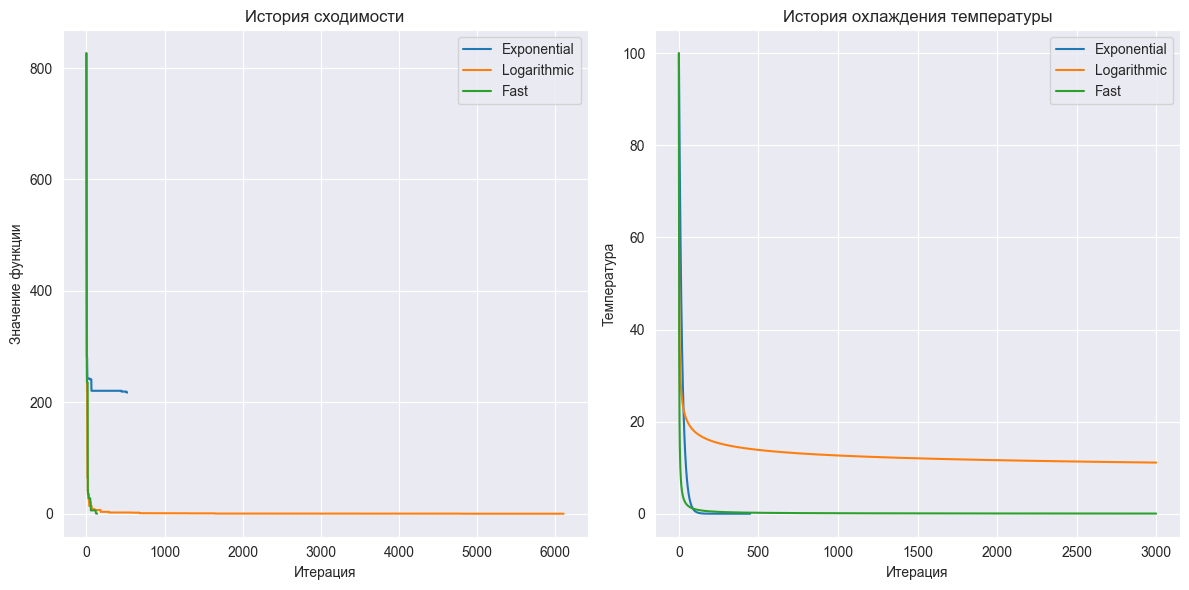

In [66]:
# Графики сходимости
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(sa_exp_cost_history, label='Exponential')
plt.plot(sa_log_cost_history, label='Logarithmic')
plt.plot(sa_fast_cost_history, label='Fast')
plt.xlabel('Итерация')
plt.ylabel('Значение функции')
plt.title('История сходимости')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(sa_exp_temp_history, label='Exponential')
plt.plot(sa_log_temp_history, label='Logarithmic')
plt.plot(sa_fast_temp_history, label='Fast')
plt.xlabel('Итерация')
plt.ylabel('Температура')
plt.title('История охлаждения температуры')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Создадим класс генетического алгоритма для сравнения

In [67]:
class GeneticAlgorithm:
    def __init__(self, cost_function, bounds, population_size=100, mutation_rate=0.01, crossover_rate=0.7):
        self.cost_function = cost_function
        self.bounds = bounds
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.population = self.initialize_population()
        self.best_solution = None
        self.best_cost = float('inf')
        self.cost_history = []

    def initialize_population(self):
        """
        Инициализация начальной популяции случайными решениями в пределах границ.
        """
        population = []
        for _ in range(self.population_size):
            solution = np.array([np.random.uniform(b[0], b[1]) for b in self.bounds])
            population.append(solution)
        return population

    def calculate_fitness(self):
        """
        Вычисление приспособленности для каждого решения в популяции (минимизация, поэтому fitness = -cost).
        """
        fitness_values = []
        for solution in self.population:
            cost = self.cost_function(solution)
            fitness_values.append(-cost) # Инвертируем для минимизации (максимизируем fitness)
            if cost < self.best_cost:
                self.best_cost = cost
                self.best_solution = solution.copy()
                self.cost_history.append(cost)
        return fitness_values

    def selection(self, fitness_values):
        """
        Турнирный отбор для выбора родительских пар.
        """
        parents = []
        for _ in range(self.population_size):
            tournament_indices = np.random.choice(range(self.population_size), size=3, replace=False) # Турнир из 3х
            tournament_fitness = [fitness_values[i] for i in tournament_indices]
            winner_index = tournament_indices[np.argmax(tournament_fitness)]
            parents.append(self.population[winner_index])
        return parents

    def crossover(self, parent1, parent2):
        """
        Одноточечный кроссовер.
        """
        if np.random.rand() < self.crossover_rate:
            crossover_point = np.random.randint(1, len(parent1))
            child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
            child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
            return child1, child2
        else:
            return parent1.copy(), parent2.copy()

    def mutation(self, child):
        """
        Мутация путем добавления небольшого случайного значения к каждой переменной.
        """
        for i in range(len(child)):
            if np.random.rand() < self.mutation_rate:
                step = (self.bounds[i][1] - self.bounds[i][0]) * 0.05 # 5% диапазона
                child[i] += np.random.uniform(-step, step)
                child[i] = np.clip(child[i], self.bounds[i][0], self.bounds[i][1]) # Ограничение границами
        return child

    def evolve(self, generations=100):
        """
        Эволюция популяции на заданное количество поколений.
        """
        for generation in range(generations):
            fitness_values = self.calculate_fitness()
            parents = self.selection(fitness_values)
            new_population = []
            for i in range(0, self.population_size, 2):
                parent1 = parents[i]
                parent2 = parents[i+1]
                child1, child2 = self.crossover(parent1, parent2)
                child1 = self.mutation(child1)
                child2 = self.mutation(child2)
                new_population.extend([child1, child2])
            self.population = new_population
        return self.best_solution, self.best_cost, self.cost_history

In [60]:
# Генетический алгоритм
ga = GeneticAlgorithm(schwefel_function, bounds)

ga_best_solution, ga_best_cost, ga_cost_history = ga.evolve(generations=200)

In [61]:
print("Лучшее решение:", ga_best_solution)
print("Лучшее значение функции:", ga_best_cost)

Лучшее решение: [420.25198841 420.948336   420.91785861]
Лучшее значение функции: 0.06522372174345037


Как видно из графиков выше, метод имитации отжига часто не находит оптимального решения, застревая в локальных минимумах, и сильно зависит от начальных условий, также обучается значительно дольше чем генетический алгоритм (хотя это зависит от выбора метода охлаждения). Генетический алгоритм, быстрее обучился и показал результат значительно лучше в данной задаче. 

Необходимо иметь в виду, что нашу целевую функцию можно было оптимизировать по каждому $x_i$ независимо друг от друга, вероятно поэтому генетический алгоритм показал себя так хорошо при маленьком числе мутаций. Возможно если бы в функции были бы нелинейные зависимости между $x_i$, генетический алгоритм показал бы себя намного хуже.